In [1]:
#Importing basic libraries
import tensorflow as tf
import pandas as pd 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt 
import os 
import pathlib 
import random
import cv2

In [2]:
path = 'C:/Users/anmol/Downloads/Breast Cancer Image segmentation/Dataset_BUSI_with_GT'
data_dir = pathlib.Path(path)

In [3]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [4]:
benignPath = os.path.join(data_dir,'bening')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')

In [5]:
imageCount = len(list(data_dir.glob('*/*.png')))
imageCount

1578

### Image Enhancement

In [6]:
def preprocess(img):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]) #Filter
    image = cv2.filter2D(img, -1, kernel)
    return image

In [7]:
testing='C:/Users/anmol/AppData/Roaming/Python/Python310/Scripts/CNN Model/Dataset_BUSI_with_GT/benign/benign (1).png'
img1=plt.imread(testing)

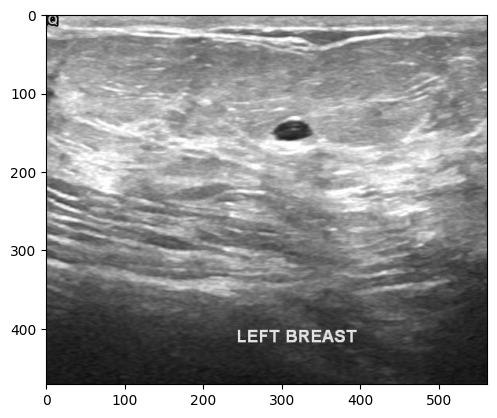

In [8]:
plt.imshow(img1)

In [9]:
img1=preprocess(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


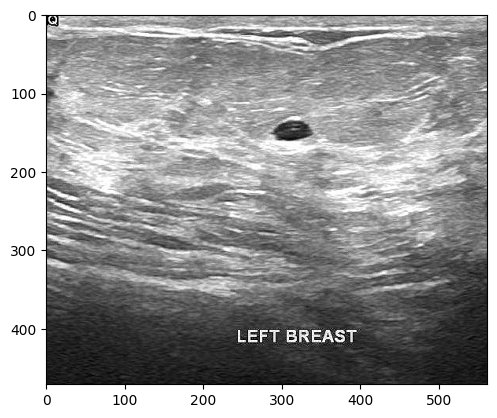

In [10]:
# Sharpened Image
plt.imshow(img1)

### Plotting of Random Images

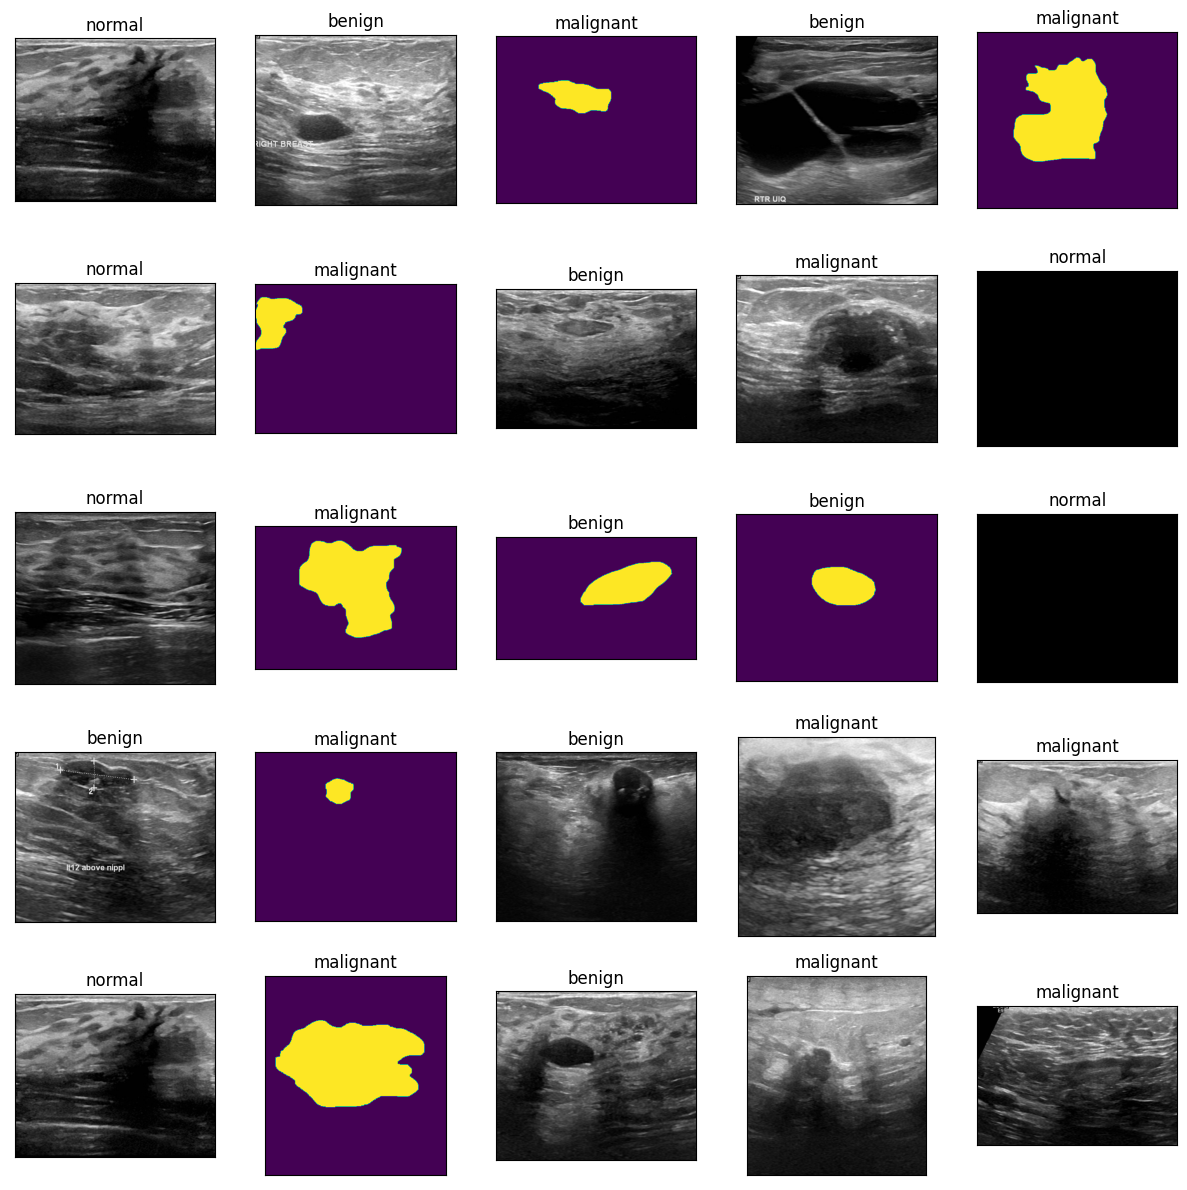

In [11]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

In [12]:
# Checking image formats

from pathlib import Path
import imghdr

data_dir = 'C:/Users/anmol/Downloads/Breast Cancer Image segmentation/Dataset_BUSI_with_GT'
image_extensions = [".png", ".jpg"]  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

### Building the model

In [13]:
batch_size = 32
img_height = 224
img_width = 224

In [14]:
# Separting the datasets

from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


### Defining the model

In [15]:
from tensorflow.keras import layers 
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

In [16]:
# Compiling the model
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

In [17]:
epochs = 2
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, 
                    batch_size=batch_size)

Epoch 1/2


C:\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 34s 834ms/step - loss: 0.9412 - accuracy: 0.5645 - val_loss: 0.7944 - val_accuracy: 0.6825
Epoch 2/2
40/40 [==============================] - 34s 848ms/step - loss: 0.6968 - accuracy: 0.6849 - val_loss: 0.7145 - val_accuracy: 0.6635


### Keys

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Accuracy v/s Loss

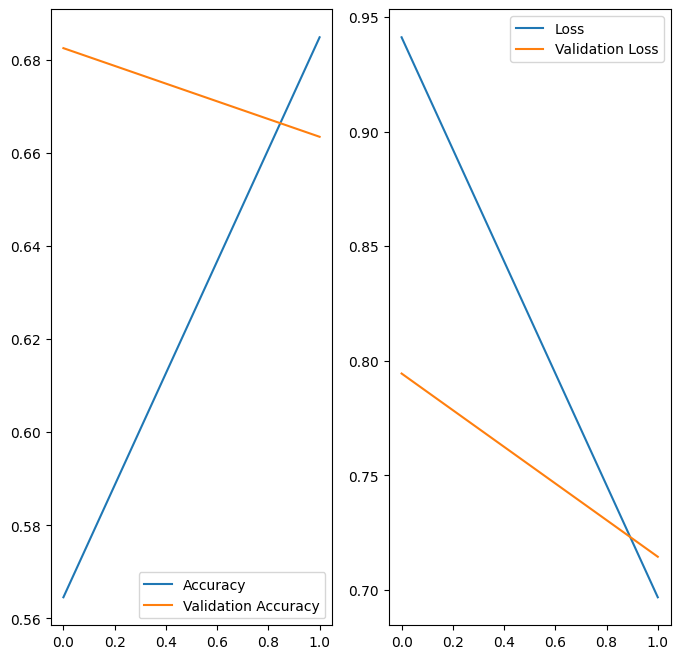

In [19]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [20]:
# Evaluating
model.evaluate(val_data)

10/10 [==============================] - 2s 165ms/step - loss: 0.7145 - accuracy: 0.6635


[0.7144731283187866, 0.6634920835494995]

In [60]:
model.predict(val_data)

10/10 [==============================] - 4s 251ms/step


array([[4.70547259e-01, 2.96427399e-01, 2.33025298e-01],
       [3.57892007e-01, 6.41973495e-01, 1.34428788e-04],
       [7.86061525e-01, 1.83251828e-01, 3.06866765e-02],
       [5.05769968e-01, 2.86372572e-01, 2.07857475e-01],
       [4.78541136e-01, 2.99312294e-01, 2.22146615e-01],
       [9.30972099e-01, 2.17813533e-02, 4.72465493e-02],
       [5.65081239e-01, 4.34917897e-01, 8.43493865e-07],
       [5.70088029e-01, 4.29906815e-01, 5.14259273e-06],
       [4.68913108e-01, 3.02414715e-01, 2.28672206e-01],
       [6.16860092e-01, 3.83135140e-01, 4.70997566e-06],
       [6.01567984e-01, 2.46571139e-01, 1.51860908e-01],
       [6.88771367e-01, 3.11203241e-01, 2.53376329e-05],
       [4.76332068e-01, 2.99246550e-01, 2.24421397e-01],
       [4.75699037e-01, 2.96681851e-01, 2.27619082e-01],
       [5.60345501e-02, 8.39615148e-03, 9.35569286e-01],
       [3.63326490e-01, 6.36673450e-01, 5.91880536e-08],
       [3.77507985e-01, 3.27079654e-01, 2.95412332e-01],
       [4.75901753e-01, 2.96596

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Saving and loading the .h5 model

In [24]:
from tensorflow.keras.models import load_model
# Saving model
model.save('cancerModel.h5')
print('Model Saved Succesfully!')

# Loading the Model
savedModel = load_model('cancerModel.h5')
savedModel.summary()

Model Saved Succesfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (N

In [56]:
from tensorflow.keras.utils import load_img
img1=load_img(testing)
img1=img1.resize((img_height, img_width))
input_arr = tf.keras.preprocessing.image.img_to_array(img1)
img = input_arr.reshape( -1,224, 224,3)
img.shape

(1, 224, 224, 3)

In [66]:
# Predicting the model
res=np.array(savedModel.predict(img))
print(res)
if(max(res[0])==res[0][0]):
    print("Benign")
elif(max(res[0])==res[1][1]):
    print("Malignant")
else:
    print("Normal")

1/1 [==============================] - 0s 64ms/step
[[0.6247342  0.23649509 0.1387707 ]]
Benign


## Predictions

1/1 [==============================] - 0s 24ms/step


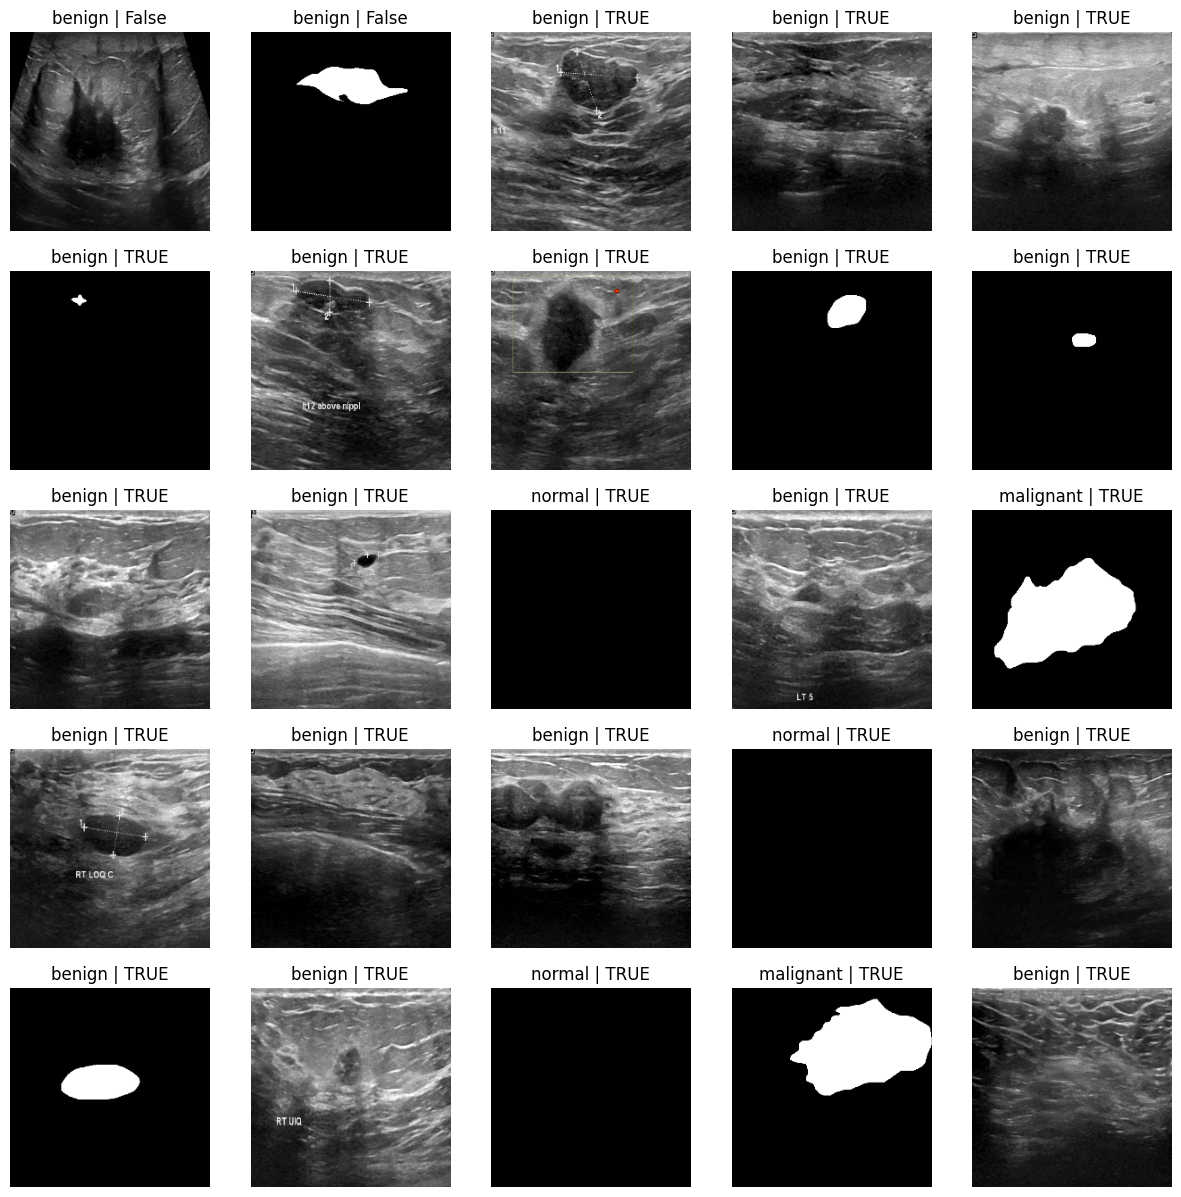

In [22]:
plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

In [2]:
import pickle
# weights is a Python array
weights=[]
pickle.dump( weights , open( 'weights.pkl' , 'wb' ) )